In [19]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from top2vec import Top2Vec

from helpers.infodynamics import InfoDynamics
from helpers.metrics import jsd, kld, cosine_distance, softmax
from helpers.afa import adaptive_filter
from tqdm import tqdm

with open('config.json','r') as f:
    cf = json.load(f)

In [20]:
cf

{'model_path': '/home/rb/Documents/Data/case-studies/dh2023-novelty/model/top2vec.model',
 'metadata_path': '/home/rb/Documents/Data/case-studies/dh2023-novelty/metadata//metadata-postwar.tsv',
 'doc_dist_path': '/home/rb/Documents/Data/case-studies/dh2023-novelty/docdist/docdist-postwar.tsv',
 'data_path': '/home/rb/Documents/Data/case-studies/dh2023-novelty/data/data.ndjson',
 'novelty_output_path': '/home/rb/Documents/Data/case-studies/dh2023-novelty/output/'}

In [21]:
data = pd.read_json(cf['data_path'],lines=True)
dists = pd.read_csv(cf['doc_dist_path'],sep='\t')

In [22]:
dists = dists.to_numpy()
dists = np.apply_along_axis(softmax,1,dists)

In [25]:
for w in [30]:
    im_vectors = InfoDynamics(
                    data = dists,
                    window = w,
                    time= data.clean_date.tolist(),
                    normalize=False
                )
    
    im_vectors.fit_save(
            meas=jsd,
            slice_w=False,
            path=os.path.join('results', f'novelty_w{w}.ndjson')
        )

In [38]:
df = pd.DataFrame(im_vectors.df)
df['date'] = pd.to_datetime(data.clean_date,infer_datetime_format=True)
df = df.sort_values('date').reset_index(drop=True)

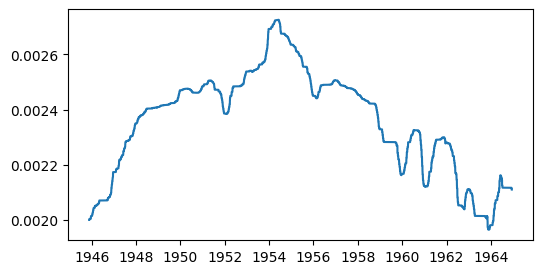

In [41]:
fig,ax = plt.subplots(figsize=(6,3))
X = df.date.tolist()
Y = np.squeeze(np.asarray(adaptive_filter(df.novelty)))
ax.plot(X,Y)